In [1]:
import json
from itertools import chain

import numpy as np
import pandas as pd
import altair as alt

import phase_shifts

In [2]:
with open("Data/Photoelectron yields - good2.json", "r") as fp:
    loaded = json.load(fp)

    
def _format(r: pd.Series):
    return "{:.0f}–{:.0f} / {:.0f}–{:.0f}".format(
        min(r["Polar ang fr (deg)"], 180 - r["Polar ang to (deg)"]),
        min(r["Polar ang to (deg)"], 180 - r["Polar ang fr (deg)"]),
        max(r["Polar ang fr (deg)"], 180 - r["Polar ang to (deg)"]),
        max(r["Polar ang to (deg)"], 180 - r["Polar ang fr (deg)"]),

    )


measu = pd.DataFrame(loaded["Data"])
measu["Polar angle range (deg)"] = measu.apply(_format, axis=1)
measu["Opt phase (deg)"] = measu["Opt phase (mach unit)"] * 360
measu.head()

,Opt phase (mach unit),Polar ang fr (deg),Polar ang to (deg),Yield,Polar angle range (deg),Opt phase (deg)
0,0.1,0.0,5.0,123.034604,0–5 / 175–180,36.0
1,0.1,5.0,10.0,294.512511,5–10 / 170–175,36.0
2,0.1,10.0,15.0,546.518591,10–15 / 165–170,36.0
3,0.1,15.0,20.0,737.338330,15–20 / 160–165,36.0
4,0.1,20.0,25.0,954.188684,20–25 / 155–160,36.0


In [3]:
phdeg = np.linspace(0, 600, 201)
phmach = phdeg / 360
it = chain.from_iterable(
    (
        {
            "Opt phase (deg)": x,
            "Yield": y,
            "Polar angle range (deg)": "{:.0f}–{:.0f} / {:.0f}–{:.0f}".format(
                min(g["Polar ang fr (deg)"], 180 - g["Polar ang to (deg)"]),
                min(g["Polar ang to (deg)"], 180 - g["Polar ang fr (deg)"]),
                max(g["Polar ang fr (deg)"], 180 - g["Polar ang to (deg)"]),
                max(g["Polar ang to (deg)"], 180 - g["Polar ang fr (deg)"]),
            ),
            "Polar ang fr (deg)": g["Polar ang fr (deg)"],
            "Polar ang to (deg)": g["Polar ang to (deg)"],
        }
        for x, y in zip(phdeg, phase_shifts.load(g["Model result"]["Params"])(phmach))
    )
    for g in loaded["Grouped by"]["Polar ang fr (deg)"]
)
fit = pd.DataFrame([d for d in it])
fit.head()

,Opt phase (deg),Polar ang fr (deg),Polar ang to (deg),Polar angle range (deg),Yield
0,0.0,0,5,0–5 / 175–180,127.089995
1,3.0,0,5,0–5 / 175–180,126.709360
2,6.0,0,5,0–5 / 175–180,126.245849
3,9.0,0,5,0–5 / 175–180,125.700732
4,12.0,0,5,0–5 / 175–180,125.075503


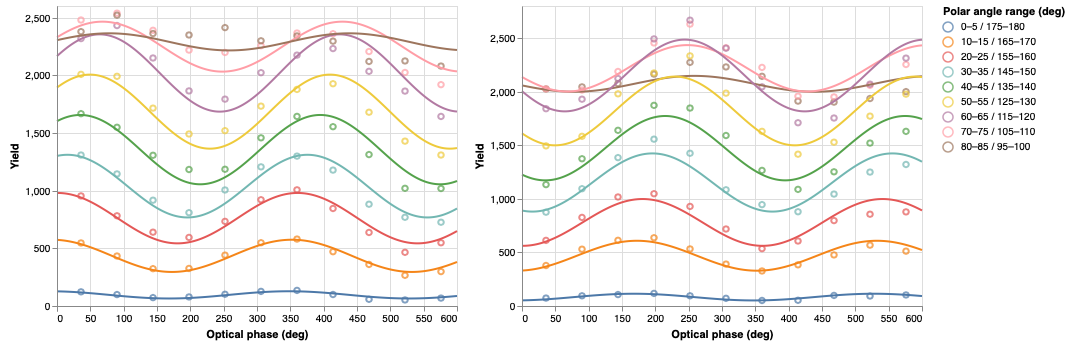

In [4]:
where = (measu["Polar ang fr (deg)"] % 10 == 0) & (measu["Polar ang fr (deg)"] < 90)
measu_top = measu[where]
where = (measu["Polar ang to (deg)"] % 10 == 0) & (90 < measu["Polar ang to (deg)"])
measu_btm = measu[where]
where = (fit["Polar ang fr (deg)"] % 10 == 0) & (fit["Polar ang fr (deg)"] < 90)
fit_top = fit[where]
where = (fit["Polar ang to (deg)"] % 10 == 0) & (90 < fit["Polar ang to (deg)"])
fit_btm = fit[where]

alt.Chart(measu_top).mark_point().encode(
    x=alt.X("Opt phase (deg)", axis=alt.Axis(title="Optical phase (deg)")),
    y="Yield",
    color=alt.Color("Polar angle range (deg)", sort=alt.EncodingSortField(field="Polar ang fr (deg)", op="max")),
) + alt.Chart(fit_top).mark_line().encode(
    x=alt.X("Opt phase (deg)", axis=alt.Axis(title="Optical phase (deg)")),
    y="Yield",
    color=alt.Color("Polar angle range (deg)", sort=alt.EncodingSortField(field="Polar ang fr (deg)", op="max")),
) | alt.Chart(measu_btm).mark_point().encode(
    x=alt.X("Opt phase (deg)", axis=alt.Axis(title="Optical phase (deg)")),
    y="Yield",
    color=alt.Color("Polar angle range (deg)", sort=alt.EncodingSortField(field="Polar ang to (deg)", op="max")),
) + alt.Chart(fit_btm).mark_line().encode(
    x=alt.X("Opt phase (deg)", axis=alt.Axis(title="Optical phase (deg)")),
    y="Yield",
    color=alt.Color("Polar angle range (deg)", sort=alt.EncodingSortField(field="Polar ang to (deg)", op="max")),
)